> # **Note for Judges: Prediction & Evaluation Notebook**
>
> This notebook is for **prediction and inference only**.
>
> Our final, pre-trained model pipelines are included in the submission folder. This script loads these `.joblib` files and runs them on the test dataset to generate our final predictions and performance metrics.
>
> **You can safely run all cells from top to bottom to reproduce our final results.**
>
> ---
> **To Retrain the Models:**
> If you wish to retrain the models from scratch, please run the `train.py` script (or `train.ipynb` notebook). This will re-run the full training process and save new `.joblib` files.

run the code cell below to make sure that the following codes work well in your colab notebook

In [ ]:
# Uncomment the code below to run on Google colab
import sys
from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/src"
sys.path.append(project_path)
print(f"Added {project_path} to Python path")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Added /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/src to Python path


# Import additional packages

In [ ]:
from preprocessing import split_data
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Lasso
- simple, interpretable baseline

### Loading the pipeline

In [ ]:
file_path = '/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/data/insurance.csv'
lasso_model_filename = 'lasso_pipeline.joblib'
parent_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/"
model_path = parent_path + lasso_model_filename

df = pd.read_csv(file_path)
X_train, X_test, y_train_log, y_test_log = split_data(df)

lasso_pipeline = joblib.load(model_path)
print(f"\nSuccessfully loaded lasso model from: {model_path}")


Successfully loaded lasso model from: /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/lasso_pipeline.joblib


### Prediction and metrics

Making predictions on the Test Set (N=268)...
create_features built successfully.

--- Actual (first 5) ---
626      6748.59120
48      12629.89670
86      43578.93940
1241    49577.66240
923      4320.41085
Name: charges, dtype: float64

--- Predictions (first 5) ---
[ 7052.07272689 11067.3623573  65210.02729504 98333.88789654
  5115.22306592]

Lasso model regression metrics (on original $ scale):
Root Mean Squared Error (RMSE): $7,718.18
Mean Absolute Error (MAE): $3,764.56
Mean Squared Error (MSE): $59,570,278.26


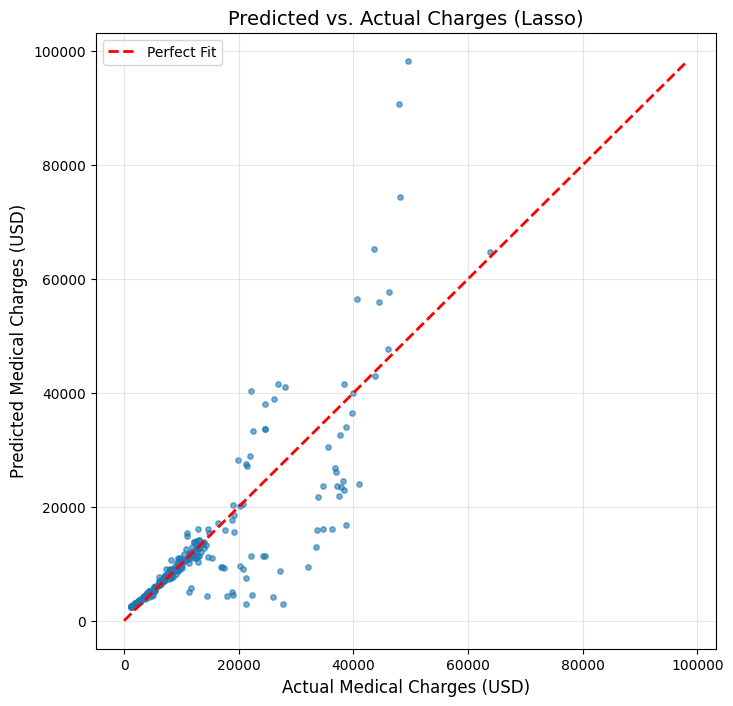

In [ ]:
print(f"Making predictions on the Test Set (N={len(X_test)})...")

# Predict using the entire pipeline (preprocessor + model)
y_pred_log_lasso = lasso_pipeline.predict(X_test)

# Inverse transform to original dollar scale
y_pred_dollars_lasso = np.expm1(y_pred_log_lasso)
y_test_dollars_lasso = np.expm1(y_test_log)

# Handle potential infinite values in predictions before calculating metrics and plotting
# Replace inf values with the maximum actual value from the test set
max_actual_value = y_test_dollars_lasso.max()
y_pred_dollars_lasso = np.nan_to_num(y_pred_dollars_lasso, posinf=max_actual_value, neginf=-max_actual_value) # Handle both pos and neg inf

# First 5 y-values
print("\n--- Actual (first 5) ---")
print(y_test_dollars_lasso[:5])

# First 5 predictions
print("\n--- Predictions (first 5) ---")
print(y_pred_dollars_lasso[:5])

# Calculate final regression metrics on the original scale
final_mse_lasso = mean_squared_error(y_test_dollars_lasso, y_pred_dollars_lasso)
final_rmse_lasso = np.sqrt(final_mse_lasso)
final_mae_lasso = mean_absolute_error(y_test_dollars_lasso, y_pred_dollars_lasso)

print("\nLasso model regression metrics (on original $ scale):")
print(f"Root Mean Squared Error (RMSE): ${final_rmse_lasso:,.2f}")
print(f"Mean Absolute Error (MAE): ${final_mae_lasso:,.2f}")
print(f"Mean Squared Error (MSE): ${final_mse_lasso:,.2f}")

# Predicted vs. Actual Scatter Plot
# This plot visually confirms the model's fit. Points close to line y = x indicate perfect predictions
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dollars_lasso, y_pred_dollars_lasso, alpha=0.6, s=15, color='#1f77b4')

max_val_lasso = max(y_test_dollars_lasso.max(), y_pred_dollars_lasso.max())
plt.plot([0, max_val_lasso], [0, max_val_lasso], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Predicted vs. Actual Charges (Lasso)', fontsize=14)
plt.xlabel('Actual Medical Charges (USD)', fontsize=12)
plt.ylabel('Predicted Medical Charges (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# plot_save_path_fit = project_path + 'Lasso_Predicted_vs_Actual_Plot.png' # Consider adding this if saving the plot is desired
# plt.tight_layout()
# plt.savefig(plot_save_path_fit)
# print(f"Predicted vs. Actual Plot saved to: {plot_save_path_fit}")
plt.show()
plt.close()

# Linear Regression on PCA



### Loading the pipeline

In [ ]:
file_path = '/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/data/insurance.csv'
linear_regression_pca_model_filename = 'linear_regression_pca_pipeline.joblib'
parent_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/"
model_path = parent_path + linear_regression_pca_model_filename

df = pd.read_csv(file_path)
X_train, X_test, y_train_log, y_test_log = split_data(df)

linear_regression_pca_pipeline = joblib.load(model_path)
print(f"\nSuccessfully loaded lasso model from: {model_path}")


Successfully loaded lasso model from: /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/linear_regression_pca_pipeline.joblib


### Prediction and metrics

Making predictions on the Test Set (N=268)...
create_features built successfully.

--- Actual (first 5) ---
626      6748.59120
48      12629.89670
86      43578.93940
1241    49577.66240
923      4320.41085
Name: charges, dtype: float64

--- Predictions (first 5) ---
[  5507.26266938  13117.10512598  59372.86690272 131923.89186255
   4812.72931494]

Linear Regression with PCA model regression metrics (on original $ scale):
Root Mean Squared Error (RMSE): $9,090.27
Mean Absolute Error (MAE): $4,235.97
Mean Squared Error (MSE): $82,633,077.76


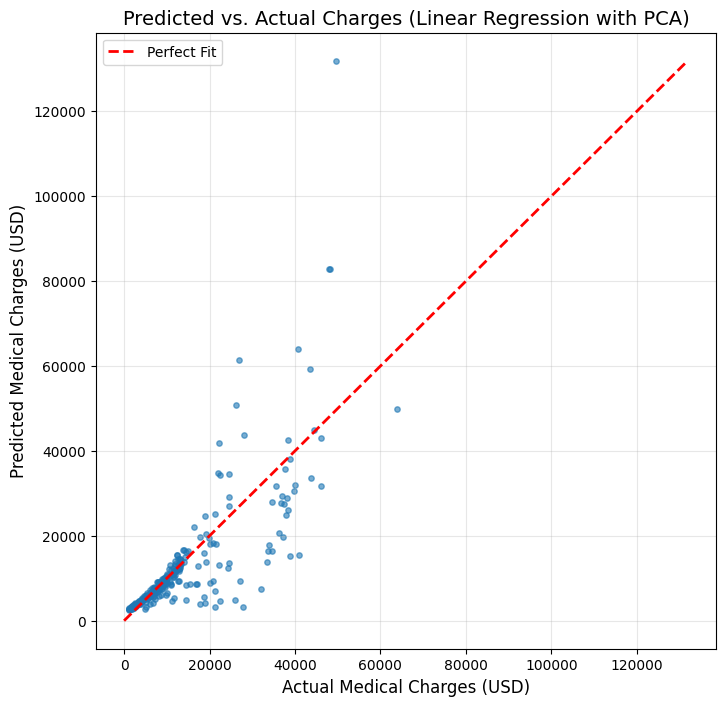

In [ ]:
if linear_regression_pca_pipeline is not None:
    print(f"Making predictions on the Test Set (N={len(X_test)})...")

    # Predict using the entire pipeline (preprocessor + model)
    y_pred_log_pca = linear_regression_pca_pipeline.predict(X_test)

    # Inverse transform to original dollar scale
    y_pred_dollars_pca = np.expm1(y_pred_log_pca)
    y_test_dollars_pca = np.expm1(y_test_log)

    # First 5 y-values
    print("\n--- Actual (first 5) ---")
    print(y_test_dollars_pca[:5])

    # First 5 predictions
    print("\n--- Predictions (first 5) ---")
    print(y_pred_dollars_pca[:5])

    # Calculate final regression metrics on the original scale
    final_mse_pca = mean_squared_error(y_test_dollars_pca, y_pred_dollars_pca)
    final_rmse_pca = np.sqrt(final_mse_pca)
    final_mae_pca = mean_absolute_error(y_test_dollars_pca, y_pred_dollars_pca)

    print("\nLinear Regression with PCA model regression metrics (on original $ scale):")
    print(f"Root Mean Squared Error (RMSE): ${final_rmse_pca:,.2f}")
    print(f"Mean Absolute Error (MAE): ${final_mae_pca:,.2f}")
    print(f"Mean Squared Error (MSE): ${final_mse_pca:,.2f}")

    # Predicted vs. Actual Scatter Plot
    # This plot visually confirms the model's fit. Points close to line y = x indicate perfect predictions
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_dollars_pca, y_pred_dollars_pca, alpha=0.6, s=15, color='#1f77b4')

    max_val_pca = max(y_test_dollars_pca.max(), y_pred_dollars_pca.max())
    plt.plot([0, max_val_pca], [0, max_val_pca], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

    plt.title('Predicted vs. Actual Charges (Linear Regression with PCA)', fontsize=14)
    plt.xlabel('Actual Medical Charges (USD)', fontsize=12)
    plt.ylabel('Predicted Medical Charges (USD)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # plot_save_path_fit_pca = project_path + 'Linear_Regression_PCA_Predicted_vs_Actual_Plot.png' # Consider adding this if saving the plot is desired
    # plt.tight_layout()
    # plt.savefig(plot_save_path_fit_pca)
    # print(f"Predicted vs. Actual Plot saved to: {plot_save_path_fit_pca}")
    plt.show()
    plt.close()

else:
    print("Linear Regression with PCA pipeline was not loaded successfully. Skipping prediction and metrics.")

# XGBoost
- final, high-performance prediction model

### Loading the pipeline

In [ ]:
file_path = '/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/data/insurance.csv'
final_model_filename = 'xgboost_final_model.joblib'
parent_path = "/content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/"
model_path = parent_path + final_model_filename

df = pd.read_csv(file_path)
X_train, X_test, y_train_log, y_test_log = split_data(df)

best_xgb_pipeline = joblib.load(model_path)
print(f"\nSuccessfully loaded XGBoost model from: {model_path}")


Successfully loaded XGBoost model from: /content/drive/MyDrive/ForestTrees/insurance_cost_prediction/models/xgboost_final_model.joblib


### Prediction and metrics

Making predictions on the Test Set (N=268)...
create_features built successfully.

--- Actual (first 5) ---
626      6748.59120
48      12629.89670
86      43578.93940
1241    49577.66240
923      4320.41085
Name: charges, dtype: float64

--- Predictions (first 5) ---
[ 6306.6436 13816.569  42872.406  47327.36    5748.4004]

XGBoost model regression metrics (on original $ scale):
Root Mean Squared Error (RMSE): $4,752.96
Mean Absolute Error (MAE): $2,092.33
Mean Squared Error (MSE): $22,590,589.76


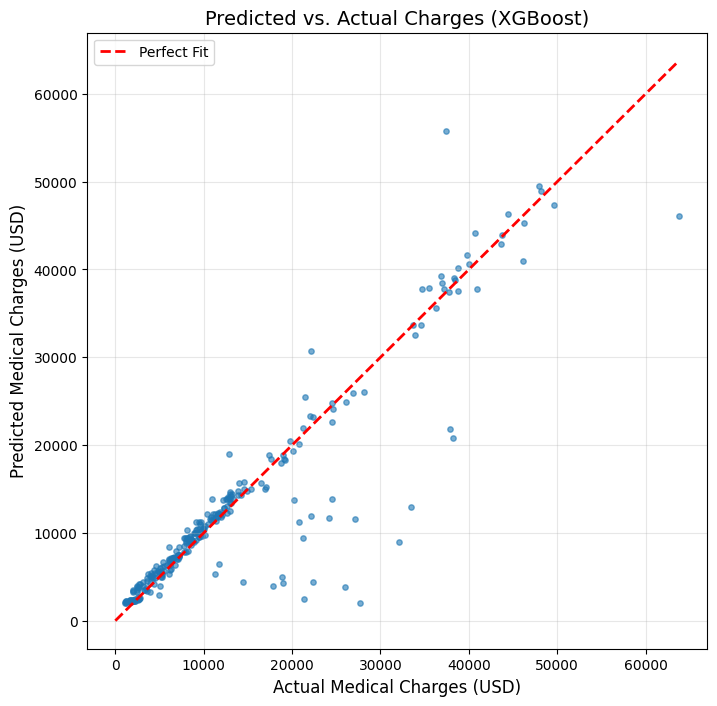

In [ ]:
print(f"Making predictions on the Test Set (N={len(X_test)})...")

# Predict using the entire pipeline (preprocessor + model)
y_pred_log = best_xgb_pipeline.predict(X_test)

# Inverse transform to original dollar scale
y_pred_dollars = np.expm1(y_pred_log)
y_test_dollars = np.expm1(y_test_log)

# First 5 y-values
print("\n--- Actual (first 5) ---")
print(y_test_dollars[:5])

# First 5 predictions
print("\n--- Predictions (first 5) ---")
print(y_pred_dollars[:5])

# Calculate final regression metrics on the original scale
final_mse_xgb = mean_squared_error(y_test_dollars, y_pred_dollars)
final_rmse_xgb = np.sqrt(final_mse_xgb)
final_mae_xgb = mean_absolute_error(y_test_dollars, y_pred_dollars)

print("\nXGBoost model regression metrics (on original $ scale):")
print(f"Root Mean Squared Error (RMSE): ${final_rmse_xgb:,.2f}")
print(f"Mean Absolute Error (MAE): ${final_mae_xgb:,.2f}")
print(f"Mean Squared Error (MSE): ${final_mse_xgb:,.2f}")

# Predicted vs. Actual Scatter Plot
# This plot visually confirms the model's fit. Points close to line y = x indicate perfect predictions
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dollars, y_pred_dollars, alpha=0.6, s=15, color='#1f77b4')

max_val = max(y_test_dollars.max(), y_pred_dollars.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Predicted vs. Actual Charges (XGBoost)', fontsize=14)
plt.xlabel('Actual Medical Charges (USD)', fontsize=12)
plt.ylabel('Predicted Medical Charges (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# plot_save_path_fit = project_path + 'XGBoost_Predicted_vs_Actual_Plot(with class imbalance handling).png'
# plt.tight_layout()
# plt.savefig(plot_save_path_fit)
# print(f"Predicted vs. Actual Plot saved to: {plot_save_path_fit}")
plt.show()
plt.close()


# Models comparison

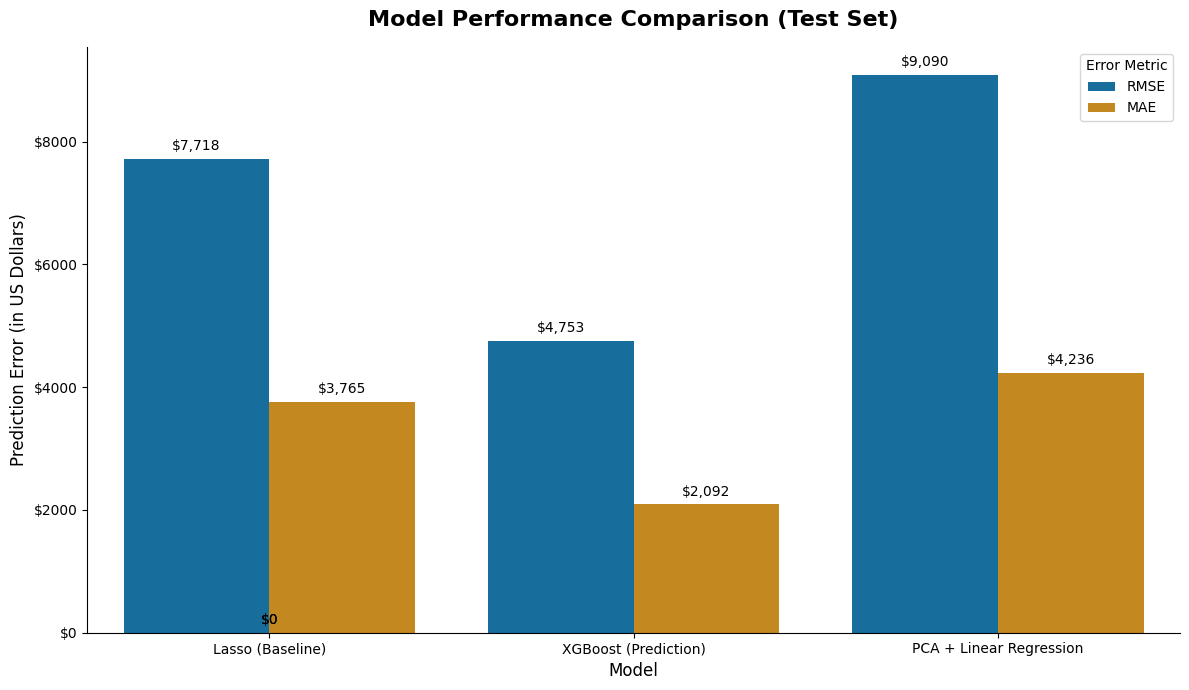

In [ ]:
# --- Prepare the data for plotting ---
# We'll create a list of dictionaries to hold our metrics
plot_data = []

# Add Lasso metrics
plot_data.append({'Model': 'Lasso (Baseline)', 'Metric': 'RMSE', 'Error ($)': final_rmse_lasso})
plot_data.append({'Model': 'Lasso (Baseline)', 'Metric': 'MAE', 'Error ($)': final_mae_lasso})

# Add XGBoost metrics
plot_data.append({'Model': 'XGBoost (Prediction)', 'Metric': 'RMSE', 'Error ($)': final_rmse_xgb})
plot_data.append({'Model': 'XGBoost (Prediction)', 'Metric': 'MAE', 'Error ($)': final_mae_xgb})

# Add PCA metrics *only if they exist* (based on your 'if' statement)
if 'final_rmse_pca' in locals():
    plot_data.append({'Model': 'PCA + Linear Regression', 'Metric': 'RMSE', 'Error ($)': final_rmse_pca})
    plot_data.append({'Model': 'PCA + Linear Regression', 'Metric': 'MAE', 'Error ($)': final_mae_pca})

# Create a DataFrame
df_metrics = pd.DataFrame(plot_data)

# --- Create the Comparison Bar Plot ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=df_metrics,
    x='Model',
    y='Error ($)',
    hue='Metric',          # Group bars by RMSE vs MAE
    palette='colorblind'   # Use a colorblind-safe palette
)

# --- Add Professional Formatting ---
ax.set_title('Model Performance Comparison (Test Set)', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Prediction Error (in US Dollars)', fontsize=12)

# Format the y-axis to show dollar signs
formatter = mtick.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

sns.despine()
plt.legend(title='Error Metric', loc='upper right')
plt.tight_layout()
plt.show()